In [1]:
import yaml
import nltk
import torch
import string
import unidecode
import numpy as np
import pandas as pd
from tqdm import tqdm
from typing import List
from nltk.corpus import stopwords
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [2]:
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


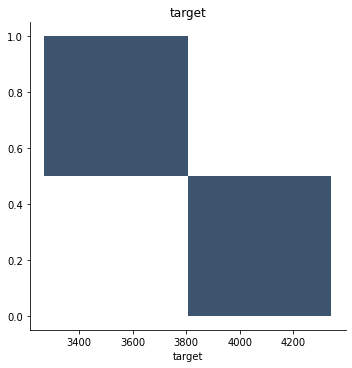

In [3]:
import matplotlib.pyplot as plt #查看target分布狀況
import seaborn as sns
locations_vc = df_train["target"].value_counts()
sns.displot(y=locations_vc.index, x=locations_vc)
plt.title("target")
plt.show()

C:\Users\90607\AppData\Local\Temp\ipykernel_16860\548184825.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train[df_train['target'] == 1]['text'].str.len(), shade=True, color='red') #依照字串長度查看分布狀況
C:\Users\90607\AppData\Local\Temp\ipykernel_16860\548184825.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train[df_train['target'] == 0]['text'].str.len(), shade=True, color= 'blue')


<AxesSubplot:xlabel='text', ylabel='Density'>

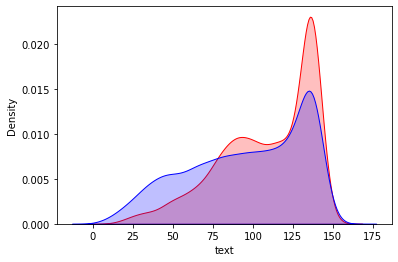

In [4]:
sns.kdeplot(df_train[df_train['target'] == 1]['text'].str.len(), shade=True, color='red') #依照字串長度查看分布狀況
sns.kdeplot(df_train[df_train['target'] == 0]['text'].str.len(), shade=True, color= 'blue')

In [5]:
import plotly.express as px
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
pie_df = pd.DataFrame({"category":sorted(["True", "False"]), 
                       "values":[x/df_train.shape[0] for x in df_train['target'].value_counts().tolist()]
                        })
fig = px.pie(pie_df, values='values', names='category', color_discrete_sequence=px.colors.sequential.RdBu)
fig.show(figsize = (4, 4))

In [6]:
abbreviations = { #用縮寫字替代內容，降低複雜度，以利寫入字雲圖
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

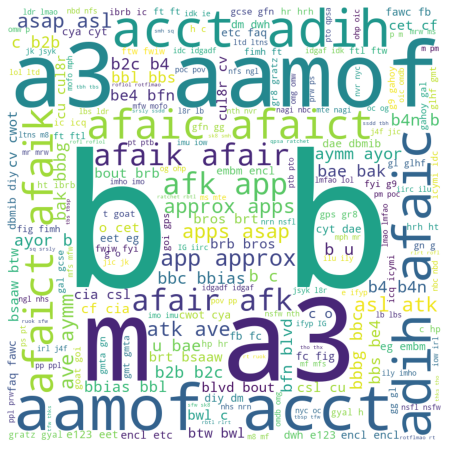

In [7]:
from wordcloud import WordCloud, STOPWORDS  #製作字雲圖，統計出現頻率高的字

comment_words = ''
stopWords = set(STOPWORDS) #引入停用詞
token = list(abbreviations.keys()) #將縮寫的字形成token列表

for i in range(len(token)):
    token[i] = token[i].lower() #列表中的元素轉成小寫，並加入comment_words
    comment_words += " ".join(token)+" "  
    
wordcloud = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stopWords,min_font_size = 10).generate(comment_words)    
               
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

停用詞 (Stop Words) 的定義上是兩個集合：
1.這個語言中出現頻繁的詞。
2.文本資料中出現頻繁的詞。

In [8]:
import re
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word #把大寫變小寫

def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

space = re.compile('[/(){}\[\]\|@,;]') #將正則表達式轉換爲模式對象，將其保存下來以利後續用
symbols= re.compile('[^0-9a-z #+_]')

def clean_text(text):
    text = text.lower() #變為小寫
    text = space.sub(' ', text) # 用空白代替space集合中的標點符號
    text = symbols.sub('', text) # 去除symbol集合中的符號數字 
    text = text.replace('x', '')
    text = replace_abbrev(text)  
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text    

In [9]:
df_train["text_clean"] = df_train["text"].apply(clean_text) #新增text_clean欄位，放處理過的語句
df_train[['text', 'text_clean', 'target']]

,text,text_clean,target
0,Our Deeds are the Reason of this #earthquake M...,deeds reason #earthquake may allah forgive us,1
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,1
2,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...,1
3,"13,000 people receive #wildfires evacuation or...",13 000 people receive #wildfires evacuation or...,1
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby #alaska smoke #wildfires p...,1
...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,two giant cranes holding bridge collapse nearb...,1
7609,@aria_ahrary @TheTawniest The out of control w...,aria_ahrary thetawniest control wild fires cal...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,m194 0104 coordinated universal time 5km s vol...,1
7611,Police investigating after an e-bike collided ...,police investigating ebike collided car little...,1


In [12]:
import tensorflow_hub as hub
sentences = df_train["text_clean"].apply(lambda x: x.lower()).tolist()
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") #引入通用句子編碼器，進行文本特徵分類
embeddings = embed([clean_text("not interested")]) #將句子轉為向量
print(embeddings.shape)

(1, 512)


In [14]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer().fit(list(set(df_train['target'].tolist()))) #將數值轉為二進位數值
embed_matrix = []

for sent in sentences:
    embed_matrix.append(np.array(embed([sent])[0]).tolist()) 
X, Y = np.array(embed_matrix), lb.transform(df_train['target'].tolist())    

In [15]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.15, shuffle=True, random_state=48) #切分訓練集和測試集

In [16]:
import tensorflow as tf
ann = tf.keras.models.Sequential() #建立神經網路
ann.add(tf.keras.Input(shape=512)) #加入輸入層，shape=512
ann.add(tf.keras.layers.Dense(units=256, activation='relu',  kernel_regularizer='l2')) #加入第一層，該層的 output neurons 數目=256，啟動函式為預設 relu，並對該層參數做 l2-regularization
ann.add(tf.keras.layers.Dropout(0.5)) #採用50%的Dropout
ann.add(tf.keras.layers.BatchNormalization())
ann.add(tf.keras.layers.Dense(units=128, activation='relu',  kernel_regularizer='l2'))
ann.add(tf.keras.layers.Dropout(rate = .5))
ann.add(tf.keras.layers.Dense(units=64, activation='relu',  kernel_regularizer='l2'))
ann.add(tf.keras.layers.Dropout(0.5))
ann.add(tf.keras.layers.BatchNormalization())
ann.add(tf.keras.layers.Dense(units=32, activation='relu',  kernel_regularizer='l2'))
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid')) #啟動函式為sigmoid
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics ='accuracy') 
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                        

In [17]:
import visualkeras #神經網路可視化
visualkeras.layered_view(ann,legend=True, draw_volume=True, spacing=30)

from keras.utils.vis_utils import plot_model
plot_model(ann, show_shapes=True, show_layer_names=True)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) #三個執行週期沒改善就停止訓練

ann.fit(train_x, train_y, epochs=50, batch_size=10, validation_split=0.3, shuffle=False, callbacks=[es_callback])#導入最佳模型

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/50
453/453 [==============================] - 4s 4ms/step - loss: 4.8674 - accuracy: 0.6341 - val_loss: 3.0649 - val_accuracy: 0.7961
Epoch 2/50
453/453 [==============================] - 1s 3ms/step - loss: 2.1454 - accuracy: 0.7565 - val_loss: 1.4082 - val_accuracy: 0.8033
Epoch 3/50
453/453 [==============================] - 2s 4ms/step - loss: 1.1561 - accuracy: 0.7664 - val_loss: 0.8811 - val_accuracy: 0.7987
Epoch 4/50
453/453 [==============================] - 2s 4ms/step - loss: 0.8318 - accuracy: 0.7730 - val_loss: 0.6850 - val_accuracy: 0.7951
Epoch 5/50
453/453 [==============================] - 2s 5ms/step - loss: 0.6989 - accuracy: 0.7748 - val_loss: 0.6188 - val_accuracy: 0.8012
Epoch 6/50
453/453 [==============================] - 3s 6ms/step - loss: 0.6758 - accuracy: 0.7781 - val_loss: 0.6130 - val_acc

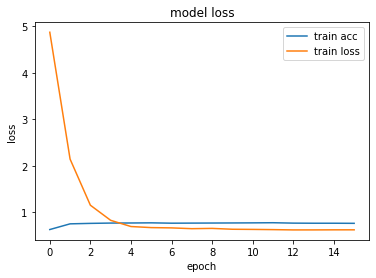

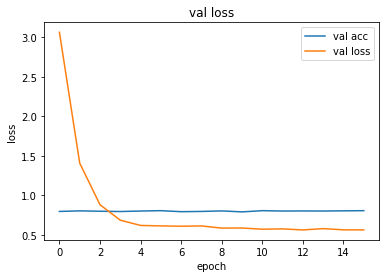

In [18]:
history = ann.history #將loss分數繪製出來
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train acc', 'train loss'], loc='upper right')
plt.show()

history = ann.history
plt.plot(history.history['val_accuracy'])
plt.title('val accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['val_loss'])
plt.title('val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val acc', 'val loss'], loc='upper right')
plt.show()

In [19]:
pred = ann.predict(test_x)
pred  = pred >.7
from sklearn.metrics import classification_report
print(classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       645
           1       0.87      0.65      0.74       497

    accuracy                           0.80      1142
   macro avg       0.82      0.79      0.79      1142
weighted avg       0.81      0.80      0.80      1142



In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
tokenizer = Tokenizer(num_words=50000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True) #把文本的每個字母都單獨切分開來
tokenizer.fit_on_texts(df_train['text'].values)
word_index = tokenizer.word_index
print('In Training data Found %s unique tokens.' % len(word_index)) #word_index的長度即為不重複的字元數量

In Training data Found 23060 unique tokens.


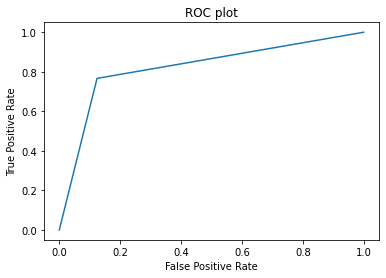

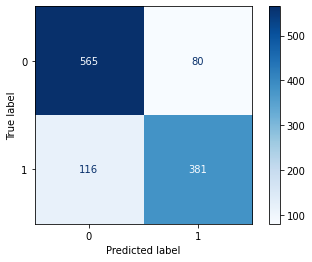

Score is :83%
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       645
           1       0.83      0.77      0.80       497

    accuracy                           0.83      1142
   macro avg       0.83      0.82      0.82      1142
weighted avg       0.83      0.83      0.83      1142



In [21]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, ConfusionMatrixDisplay,classification_report
xgb = XGBClassifier()
xgb.fit(train_x, train_y)
fpr, tpr, _ = roc_curve(test_y, xgb.predict(test_x) , pos_label=1)
plt.plot(fpr,tpr)
plt.title("ROC plot")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

cm_rm_2 = confusion_matrix(test_y, xgb.predict(test_x)) #用混淆矩陣查看預測與訓練分布
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rm_2)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print(f"Score is :{round(accuracy_score(test_y, xgb.predict(test_x))*100)}%")
print(classification_report(test_y, xgb.predict(test_x)))

In [22]:
from lazypredict.Supervised import LazyClassifier #用lazypredict套件，看哪一種模型比較高分
clf = LazyClassifier(verbose=0,ignore_warnings=False, custom_metric=None)
models, predictions = clf.fit(train_x, test_x, train_y, test_y)
models 

 17%|█▋        | 5/29 [01:17<05:00, 12.53s/it]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


 90%|████████▉ | 26/29 [02:35<00:15,  5.13s/it]

StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'


100%|██████████| 29/29 [02:50<00:00,  5.88s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.83,0.83,0.83,0.83,11.84
LGBMClassifier,0.83,0.82,0.82,0.83,3.22
NuSVC,0.83,0.82,0.82,0.83,19.62
XGBClassifier,0.83,0.82,0.82,0.83,12.25
CalibratedClassifierCV,0.82,0.81,0.81,0.82,28.05
LinearDiscriminantAnalysis,0.82,0.81,0.81,0.82,1.20
RidgeClassifierCV,0.82,0.81,0.81,0.82,0.78
RidgeClassifier,0.82,0.81,0.81,0.82,0.33
RandomForestClassifier,0.82,0.81,0.81,0.82,9.90


In [23]:
from sklearn.svm import SVC #由上面分析可知，採取SVC支持向量分類器，表現最佳
svc = SVC(gamma='auto')
svc.fit(train_x, train_y)
res = pd.DataFrame({"id" : df_test['id'].tolist(),"target": ann.predict(embed(df_test['text'].apply(clean_text).values)).tolist()}, columns=["id", "target"]).reset_index(drop=True)
res.to_csv("sample_submission.csv", index=False)